In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture

import os
import sys

In [78]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('omniglot', 128, False,
                                                                       N_WAY_TEST=5,
                                                                       K_SHOT_TEST=1,
                                                                       N_QUERY_TEST=15,
                                                                       N_TEST_EPISODES=1000)

Initializing EpisodeDataset: Indexing dataset by class...
--> Manually indexing dataset by class (can be slow for large datasets)...
    (Dataset lacks `get_label` method, will load items via __getitem__ for indexing)
--> Manual indexing complete. Found 659 valid classes.
-> Indexing complete in 7.48 seconds.
-> Found 659 classes with enough samples.
EpisodeDataset ready: Using 659 classes for 5-way 1-shot tasks (15 query samples/class).
Generating 1000 episodes per epoch.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [54]:
n_layers=11
model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=32*3*3,
    dec_hidden_dim=(32,3,3),
    input_dim=1*28*28,
    latent_dim=8,
    encoder_name='mnist',
    decoder_name='mnist',
    kl1_weight=1
).to(device)
path = '/nethome/zwang910/file_storage/nips-2025/deep-taxon/project-checkin/'
run = 'vade-11-reg-3/'
# run = 'vade-11-reg-1-fmnist/'
checkpoint = 'deep_taxon_280.pt'
model.load_state_dict(torch.load(f'{path}{run}{checkpoint}'))

<All keys matched successfully>

In [24]:
annotation = utils.label_annotation(model, train_set, 10, device)
acc = utils.basic_node_evaluation(model, annotation, test_set, device)
print('acc:', acc)

pred shape: torch.Size([10000, 10])
acc: 0.8155


## Few-shot testing

In [79]:
utils.testing_few_shot(model, test_loader, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:06<00:00, 15.05it/s]

Few-shot accuracy: 0.5509


0.5508533333333333

,u_c.shape: torch.Size([4095, 8])


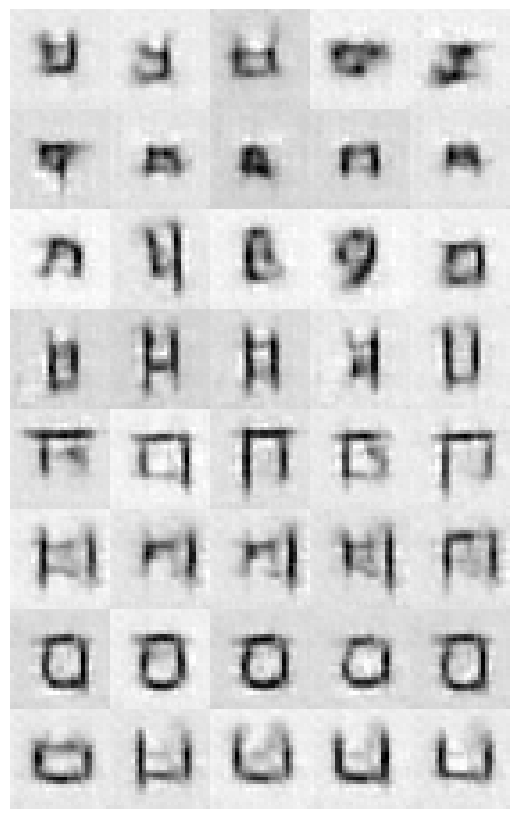

In [80]:
offset = 80
layer = 11
n_examples = 5
subset_len = 8

pi, mu_c, logvar_c, H, alphas, dkl_list = model.gmm_params()
print(',u_c.shape:', mu_c.shape)

mu_c = mu_c[offset:offset+subset_len, :].unsqueeze(1).expand(-1, n_examples, -1).reshape(-1, mu_c.shape[-1]) # shape: (n_clusters * n_examples, n_hidden)
logvar_c = logvar_c[offset:offset+subset_len, :].unsqueeze(1).expand(-1, n_examples, -1).reshape(-1, logvar_c.shape[-1]) # shape: (n_clusters * n_examples, n_hidden)

# print(f"mu_c shape: {mu_c.shape}")
# break

eps = torch.randn_like(mu_c)  # shape: (n_clusters * n_examples, n_hidden) 
# make the noise smaller
eps = eps
z = mu_c + torch.exp(logvar_c / 2) * eps  # shape: (n_clusters * n_examples, n_hidden)
x = model.decode(z.to(device))  # shape: (n_clusters * n_examples, C, H, W)
x = x.view(-1, n_examples, *x.shape[1:]).detach().cpu().numpy()  # shape: (n_clusters, n_examples, C, H, W)

n_clusters = x.shape[0]

# generate small noise for each cluster for each example
# Create subplots: n_clusters rows and n_examples columns.
fig, axes = plt.subplots(n_clusters, n_examples, figsize=(n_examples, n_clusters))
# Force the axes array to be 2D.
if n_clusters == 1 and n_examples == 1:
    axes = np.array([[axes]])
elif n_clusters == 1:
    axes = np.expand_dims(axes, axis=0)
elif n_examples == 1:
    axes = np.expand_dims(axes, axis=1)
    
# Loop over clusters and examples to display each generated image.
for i in range(n_clusters):
    for j in range(n_examples):
        ax = axes[i, j]
        img = x[i, j]
        # If the image is grayscale (1 channel), remove the extra dimension.
        if img.shape[0] == 1:
            img = img.squeeze(0)
            ax.imshow(img, cmap='gray')
        else:
            # For color images, convert from (C, H, W) to (H, W, C)
            # img = np.transpose(img, (1, 2, 0))
            # print(f"img shape: {img.shape}")
            # print(f"img shape: {img.shape}")
            ax.imshow(img.transpose(1, 2, 0))
        ax.axis("off")  # Remove axis ticks and labels

# Remove spacing between subplots.
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
# return fig
plt.show()